In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [3]:
protected = ["sex"]
privileged_classes = [['Male']]
metadata = default_mappings.copy()
metadata['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]

alpha = 0.5
beta = 1

kwargs = {'protected_attribute_names': protected,
          'privileged_classes': [['Male']],
          'metadata':metadata,
          'favorable_classes': [1],
          'beta': beta,
          'alpha': alpha
         }

random_state = 47
model_type = GaussianNB

In [4]:
from copy import deepcopy
dist = {
    'mu_ps': {'p': 3, 'u': 0},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

results = {'p' : [], 'u': [], 'm': []}
deltas = []
start = 1
end = 20
for i in range(start, end):
    temp_dist = deepcopy(dist)
    mu_ps = temp_dist['mu_ps']
    for k in mu_ps:
        mu_ps[k] = mu_ps[k] + i
    kwargs['dist'] = temp_dist
    print(kwargs['dist'])    
    
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 2, 1, kwargs, test_random_state=23)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    # is_u_optimal = umod_results[4] >= pmod_results[4] and umod_results[4] >= mod_results[4] 
    is_u_optimal = umod_results[4] > pmod_results[4]
    # is_p_optimal = pmod_results[3] >= umod_results[3] and pmod_results[3] >= mod_results[3]
    is_p_optimal = pmod_results[3] > umod_results[3]
    is_m_optimal = mod_results[2] > umod_results[2] and mod_results[2] > pmod_results[2]
    
    opt_diff = is_u_optimal and is_p_optimal and is_m_optimal
    
    violates = mod_results[1] > umod_results[1] and mod_results[1] > pmod_results[1]
    
    kwargs['verbose'] = True
    if kwargs['verbose']:
        print(opt_diff)
    
        print('Violates', opt_diff and violates)
    
        print('pmod_results', *pmod_results, sep='\t')
        print('umod_results', *umod_results, sep='\t')
        print('mod_results', *mod_results, sep='\t')
    assert not (opt_diff and violates)
    
    # if opt_diff and not violates:
    results['p'].append(pmod_results)
    results['u'].append(umod_results)
    results['m'].append(mod_results)

    # print(kwargs)

{'mu_ps': {'p': 4, 'u': 1}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 5}}
False
Violates False
pmod_results	-0.25599999999999995	0.5308777716694155	0.5998	0.6359	0.5637	0.6816	0.4098	0.3534	0.226
umod_results	-0.09160000000000001	0.8676874187490972	0.6035	0.6019	0.6051	0.7942	0.5904	0.7058	0.4956
mod_results	-0.1613	0.7591818453269633	0.60345	0.6078	0.5991	0.7776	0.562	0.6076	0.4094
{'mu_ps': {'p': 5, 'u': 2}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 5}}
False
Violates False
pmod_results	-0.23099999999999998	0.5499707773232028	0.6467	0.7083	0.5851	0.7216	0.305	0.3674	0.1972
umod_results	-0.1935	0.737163814180929	0.62335	0.6232	0.6235	0.8594	0.613	0.6662	0.4192
mod_results	-0.2562	0.6256575102279369	0.6334	0.65	0.6168	0.8344	0.5344	0.545	0.3114
{'mu_ps': {'p': 6, 'u': 3}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 5}}
False
Violates False
pmod_results	-0.22550000000

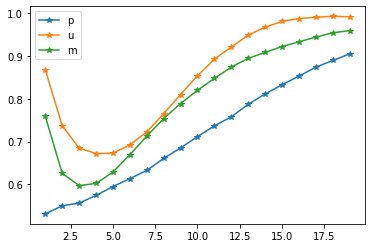

In [5]:
plt.plot(range(start, end), [i[1] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [i[1] for i in results['u']], '*-', label='u')
plt.plot(range(start, end), [i[1] for i in results['m']], '*-', label='m')
plt.legend()

0.006000000000000005 0.028100000000000014
-0.09599999999999997 -0.15220000000000006 0.09819999999999995 0.0862
0.006700000000000039 0.05830000000000002
-0.11280000000000001 -0.2294 0.12119999999999997 0.1078
0.00869999999999993 0.07569999999999999
-0.09660000000000002 -0.24799999999999997 0.12119999999999997 0.1038
0.00649999999999995 0.0786
-0.0776 -0.2348 0.11960000000000004 0.10659999999999997
0.005600000000000049 0.07080000000000009
-0.06020000000000003 -0.2018 0.11020000000000008 0.09900000000000003
0.009599999999999942 0.060800000000000076
-0.042200000000000015 -0.1638 0.10440000000000005 0.08520000000000003
0.011800000000000033 0.05069999999999997
-0.025000000000000022 -0.12639999999999998 0.0978 0.07419999999999999
0.013599999999999945 0.038000000000000034
-0.01639999999999997 -0.0924 0.09440000000000004 0.06720000000000001
0.012499999999999956 0.027800000000000047
-0.00979999999999992 -0.0654 0.0868000000000001 0.061799999999999994
0.01090000000000002 0.01869999999999994
-0.00

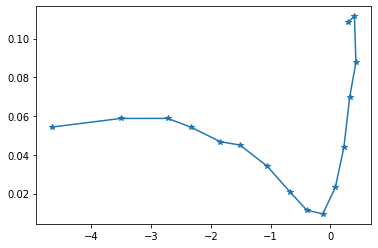

In [6]:
c_by_ds = []
di_diffs = []
for i in range(0, end - start):
    pmod_res = results['p'][i]
    umod_res = results['u'][i]
    mod_res = results['m'][i]
    di_u = umod_res[1]
    di = mod_res[1]
    acc_diff_u =  umod_res[4] - mod_res[4]
    acc_diff_p = pmod_res[3] - mod_res[3]
    print(acc_diff_u, acc_diff_p)
    del_p_plus = pmod_res[5] - mod_res[5] 
    del_p_minus = pmod_res[6] - mod_res[6]

    del_u_plus = umod_res[7] - mod_res[7]
    del_u_minus = umod_res[8] - mod_res[8]
    print(del_p_plus, del_p_minus, del_u_plus, del_u_minus)
    c = acc_diff_u + 2 * (1-alpha) * del_u_minus
    d = acc_diff_p + 2 * (1-alpha) * del_p_minus
    if d == 0:
        break
    c_by_ds.append(c/d)
    di_diffs.append(di_u - di)
    if c > d:
        assert di < di_u
        
print(*list(zip(c_by_ds, di_diffs)),sep='\n')

plt.plot(-np.log(np.abs(c_by_ds)), di_diffs, '*-')

In [7]:
acc_diff_u = [(i[0][4] - i[1][4]) for i in zip(results['u'], results['m'])]
acc_diff_u
acc_diff_p = [(i[0][3] - i[1][3]) for i in zip(results['p'], results['m'])]
acc_diff_p
di_diff = [i[0][1] - i[1][1] for i in zip(results['u'], results['m'])]
di_diff

[0.10850557342213385,
 0.1115063039529921,
 0.08766558275509939,
 0.06987978066654377,
 0.043858666344377295,
 0.023237904107721308,
 0.009487718646730148,
 0.011460058861760491,
 0.021003264910936847,
 0.03418341577296169,
 0.04503331693803736,
 0.04676503571324497,
 0.05427929456806546,
 0.05877848287143639,
 0.058763959391859744,
 0.054286556778803896,
 0.04644966175885401,
 0.03861723862729449,
 0.032410067918497654]

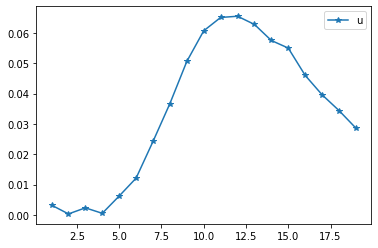

In [8]:
#plt.plot(range(-10, n), [i[3] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [abs(i[3] - i[4]) for i in results['u']], '*-', label='u')
#plt.plot(range(-10, n), [i[2] for i in results['m']], '*-', label='m')
plt.legend()

In [9]:
dist = {
    'mu_ps': {'p': 13, 'u': 10},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

model_results = {'p': [], 'u': [], 'm': []}
kwargs['dist'] = dist
model_types = [GaussianNB, LogisticRegression, DecisionTreeClassifier]
for model_type in model_types:
    
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 10, 3, kwargs, test_random_state=47)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    kwargs['verbose'] = True
    if kwargs['verbose']:
        print(opt_diff)
    
        print('Violates', opt_diff and violates)
    
        print('pmod_results', *pmod_results, sep='\t')
        print('umod_results', *umod_results, sep='\t')
        print('mod_results', *mod_results, sep='\t')
    model_results['p'].append(pmod_results)
    model_results['u'].append(umod_results)
    model_results['m'].append(mod_results)


False
Violates False
pmod_results	-0.11830000000000002	0.7634	0.93905	1.0	0.8781	1.0	0.0	0.7598	0.0036
umod_results	-0.018900000000000028	0.9637166442695334	0.97215	0.9791	0.9652	1.0	0.0418	0.9672	0.0368
mod_results	-0.04320000000000007	0.9137035557331201	0.9732	0.9994	0.947	1.0	0.0012	0.9044	0.0104
False
Violates False
pmod_results	-0.11129999999999995	0.7775334799120528	0.94135	0.9997	0.883	1.0	0.0006	0.772	0.006
umod_results	-0.01770000000000005	0.9659090909090908	0.96805	0.9808	0.9553	1.0	0.0384	0.9568	0.0462
mod_results	-0.02510000000000001	0.9501786423183803	0.97455	0.9962	0.9529	1.0	0.0076	0.9316	0.0258
False
Violates False
pmod_results	-0.11009999999999998	0.7798	0.93075	1.0	0.8615	1.0	0.0	0.7514	0.0284
umod_results	-0.04690000000000005	0.9159949847752104	0.94815	0.9417	0.9546	1.0	0.1166	0.966	0.0568
mod_results	-0.027700000000000002	0.9447326416600159	0.97135	0.9988	0.9439	1.0	0.0024	0.9174	0.0296


In [10]:
dist

{'mu_ps': {'p': 13, 'u': 10},
 'sigma_ps': {'p': 2, 'u': 5},
 'mu_ns': {'p': 3, 'u': 0},
 'sigma_ns': {'p': 2, 'u': 5}}

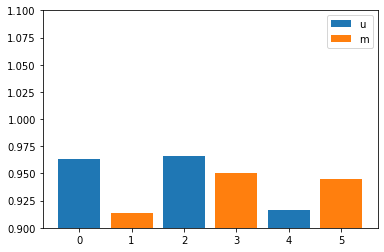

In [11]:
plt.bar(range(0, len(model_types)*2, 2), [i[1] for i in model_results['u']], label='u')
plt.bar(range(1, len(model_types)*2, 2), [i[1] for i in model_results['m']], label= 'm')
plt.ylim(0.9, 1.1)
plt.legend()

In [12]:
from copy import deepcopy
dist = {
    'mu_ps': {'p': 13, 'u': 10},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

results = {'p' : [], 'u': [], 'm': []}
start = 0
end = 10
for i in range(start, end):
    temp_dist = deepcopy(dist)
    sigma_ps = temp_dist['sigma_ps']
    sigma_ns = temp_dist['sigma_ns']
    sigma_ps['u'] = sigma_ps['u'] + i
    sigma_ns['u'] = sigma_ns['u'] + i

    print(temp_dist)    
    kwargs['dist'] = temp_dist
    kwargs['verbose'] = False
    
    train_fd, test_fd = get_datasets(10000, 2, 1, kwargs, test_random_state=47)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    results['p'].append(pmod_results)
    results['u'].append(umod_results)
    results['m'].append(mod_results)

    # print(kwargs)

{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 5}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 6}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 6}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 7}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 7}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 8}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 8}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 9}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 9}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 10}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 10}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 11}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 11}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 12}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 12}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 13

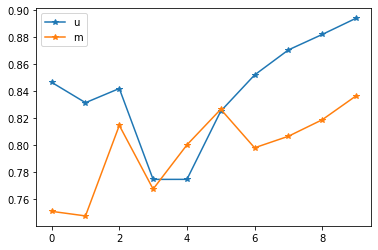

In [13]:
plt.plot(range(start, end), [i[1] for i in results['u']], '*-', label='u')
plt.plot(range(start, end), [i[1] for i in results['m']], '*-', label='m')
plt.legend()

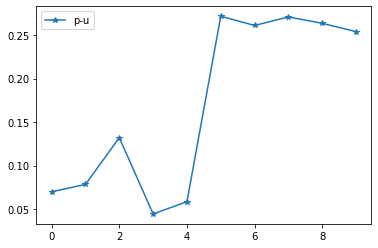

In [14]:
#plt.plot(range(-10, n), [i[3] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [abs(i[3] - i[4]) for i in results['u']], '*-', label='p-u')
#plt.plot(range(-10, n), [i[2] for i in results['m']], '*-', label='m')
plt.legend()